In [1]:
import os
import collections
import json
import pickle
from tqdm import tqdm

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 20)
pd.options.display.max_rows = 100

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import langid
from src.wimbd_ import WimbdAnalysis, WimbdTasks, display_language_pairs

bigram = "bonjour"  # Replace with your bigram
language, _ = langid.classify(bigram)
print("Detected language:", language)

/local/home/antonis/.conda/envs/incidental/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /local/home/antonis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /local/home/antonis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
initializing identifier


Detected language: en


In [3]:
# pth = "/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/results/n-grams/wmt/pile/exp4/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue/2/all/('cs', 'en').pkl"
# with open(pth, "rb") as f:
#     data = pickle.load(f)

In [4]:
# lang params
N_GRAMS = 1
BASE_DIR = f"./results/n-grams/wmt/pile/exp4/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue"
# BASE_DIR = f"./results/n-grams/exp_full/"

BASE_PATH = os.path.join(BASE_DIR, str(N_GRAMS))
BASE_PATH_COMMON = os.path.join(BASE_PATH, "common")
BASE_PATH_ALL = os.path.join(BASE_PATH, "all")
FILTER_CHARS = False
DETECT_LANG = False
PERCENTILE = 0.1

# model params
base_results_path = "/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/pythia/experiment_3/inference/EleutherAI"
models = ['pythia-12b', 'pythia-6.9b', 'pythia-2.8b', 'pythia-1.4b', 'pythia-410m', 'pythia-160m', 'pythia-70m', 'pythia-31m', 'pythia-14m',]


In [5]:
n_gram_freqs_path = "./results/n-grams/exp_full/2/common/pl-en-2-grams.pkl"
n_gram_freqs = pickle.load(open(n_gram_freqs_path, "rb"))
n_gram_freqs = dict(sorted(n_gram_freqs.items(), key=lambda item: item[1]['value'], reverse=True))
# # export as text
# # with open("n_gram_freqs.txt", "w") as f:
# #     for k, v in n_gr
# # 3am_freqs.items():
# #         f.write(f"{k}: {v}\n")
# LANGUAGES = ['ru-en', 'fr-en', 'ro-en', 'de-en', 'pl-en', 'cs-en']
# LANGUAGES = ['ru-en', 'ro-en', 'de-en', 'pl-en', 'cs-en', 'fr-en', 'ja-en', 'zh-en']

# wmt09
LANGUAGES = ['wmt09-cs-en', 'wmt09-de-en', 'wmt09-fr-en', 'wmt09-es-en', 'wmt09-it-en', 'wmt09-hu-en']


wa = WimbdAnalysis(BASE_PATH, LANGUAGES, N_GRAMS, FILTER_CHARS)
wt = WimbdTasks()


LANGUAGES_STR = "_".join(LANGUAGES)
PLOT_PATH = f"./results/n-grams/exp_full/{N_GRAMS}/plots/{LANGUAGES_STR}_filter_{FILTER_CHARS}"
if not os.path.exists(PLOT_PATH):
    os.makedirs(PLOT_PATH)

In [18]:
# lang_dfs_all = wa.get_lang_dfs(BASE_PATH_ALL, LANGUAGES, filter_chars=False,
#                               percentile=0.95)
lang_dfs_common = wa.get_lang_dfs(BASE_PATH_COMMON, LANGUAGES, filter_chars=FILTER_CHARS,
                                    percentile=0.95, n_gram=N_GRAMS)
# lang_dfs_common_0 = wa.get_lang_dfs(BASE_PATH_COMMON, LANGUAGES, filter_chars=FILTER_CHARS,
#                                     percentile=0.0)
# lang_dfs_all_filtered = wa.get_lang_dfs(BASE_PATH_ALL, LANGUAGES, filter_chars=True,
#                                         percentile=0.95, detect_lang=False, filter_entities=True)
# lang_dfs_common_filtered = wa.get_lang_dfs(BASE_PATH_COMMON, LANGUAGES, filter_chars=False,
#                                            percentile=0.999, detect_lang=False, filter_entities=True)
lang_dfs = lang_dfs_common

# get total samples per language pair
lang_dfs_total_samples = {lang: df['value'].sum() for lang, df in lang_dfs.items()}
colors = sns.color_palette('hls', len(lang_dfs))
color_mapping = {lang: color for lang, color in zip(lang_dfs.keys(), colors)}

# lang_dfs_common = lang_dfs_filtered

saved file: lang_dfs_filter_charsFalse_percentile0.95_n_gram1.pkl in ./results/n-grams/wmt/pile/exp4/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue/1/common


In [38]:
lang_dfs_new = "./results/n-grams/exp_full/2/examples_dfs_0-shot_common_models.pkl"
model_instance_pth = "./results/n-grams/exp_full/2/model_instance_results_0-shot_common.pkl"
lang_dfs_new = pickle.load(open(lang_dfs_new, "rb"))
model_instance_results = pickle.load(open(model_instance_pth, "rb"))

In [39]:
examples = lang_dfs_new['pythia-12b']
examples.head(2)

,lang_1,lang_2,value,example,coverage,task,query,sum,count,id,gold,src,ref,result,bleu
0,temps après,first time,186.0,"[temps après, first time]",0.066915,fr-en,"['temps après', 'first time']",186.0,1,2947_4,0,"Peu de temps après, le témoin, qui au début n'...","Shortly after, the witness, who, in a first ti...","A few minutes later, the witness, who at firs...",28.795572
1,temps après,time apparently,2.0,"[temps après, time apparently]",0.066915,fr-en,"['temps après', 'time apparently']",2.0,1,2947_4,0,"Peu de temps après, le témoin, qui au début n'...","Shortly after, the witness, who, in a first ti...","A few minutes later, the witness, who at firs...",28.795572


In [49]:
def get_model_results_from_df(df, metric='bleu'):
    """"
    returns a dict of structure {task: {model:{scores, nsamples}}
    """
    model2score = {}
    dataset2score = {}
    for model, model_results in df.items():
        for task in sorted(model_results['task'].unique()):
            if model not in model2score:
                model2score[model] = {'score': [], 'n_samples': []}
            if task not in dataset2score:
                dataset2score[task] = {'score': [], 'n_samples': []}
            task_df = model_results[model_results['task'] == task]
            task_score = task_df.iloc[0]['bleu']
            task_n_samples = task_df['value'].sum()
            model2score[model]['score'].append(task_score)
            model2score[model]['n_samples'].append(task_n_samples)
            dataset2score[task]['score'].append(task_score)
            dataset2score[task]['n_samples'].append(task_n_samples)
    return model2score, dataset2score

def get_task_ngrams_from_df(df):
    examples = df['pythia-12b'] # the ngram vals are same for all models
    tasks = examples['task'].unique()
    task_ngrams = {}
    for task in tasks:
        task_ngrams[task] = {'score': [], 'n_samples': []}
        task_df = examples[examples['task'] == task]
        score = task_df.iloc[0]['bleu']
        # n_samples = 
        task_ngrams[task] = task_df
    return task_ngrams


model2score, dataset2score = get_model_results_from_df(lang_dfs_new)
task_ngrams = get_task_ngrams_from_df(lang_dfs_new)

Saved figure to ./results/n-grams/wmt/pile/exp4/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue/1/plots/lang_scores_XY_pairs.png


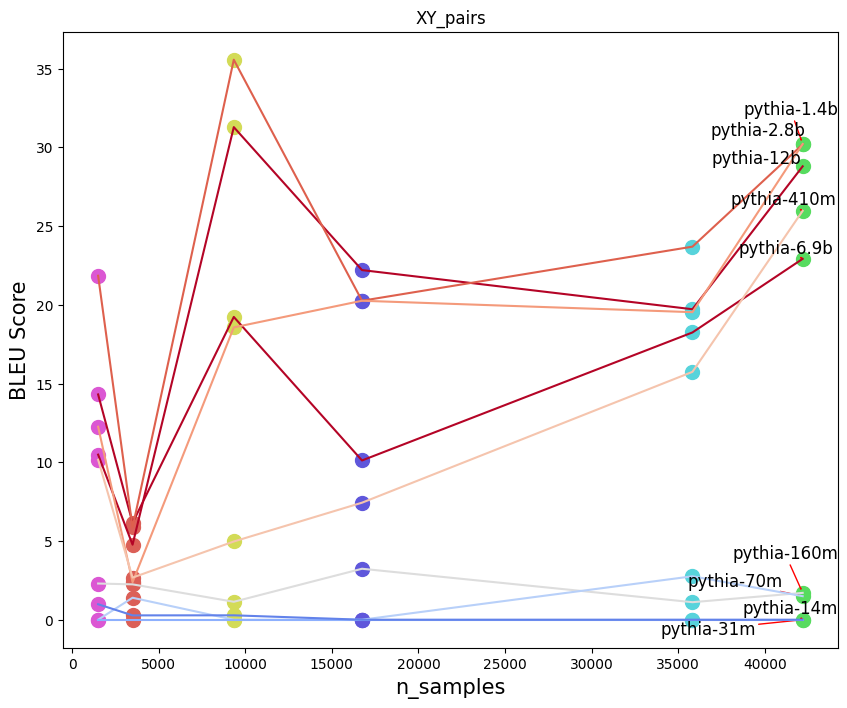

: 

In [53]:
wa.plot_scores(model2score, dataset2score, color_mapping,
               model_color_mapping, name="XY_pairs")

In [ ]:
model_scores_new, dataset_scores_new = wa.prepare_scores(results_dict, lang_dfs_new, models,
                                                         mutual_info=lang_mutual_info,
                                                         merged_mutual_info=merged_mutual_info)

In [26]:
# save_path = f"./results/n-grams/exp_full/{N_GRAMS}/common"
# # for each language, save top 100 examples in a csv

# for lang, df in lang_dfs.items():
#     df = df.sort_values(by=['value'], ascending=False)
#     df.to_csv(os.path.join(save_path, f"{lang}_samples.csv"), index=False)

# for lang, df in lang_dfs_filtered.items():
#     df = df.sort_values(by=['value'], ascending=False)
#     df = df.head(100)
#     df.to_csv(os.path.join(save_path, f"{lang}_samples_filtered.csv"), index=False)

# n_gram_freqs_all = wa.get_lang_dfs(BASE_PATH_ALL, datasets=LANGUAGES, is_all=True, filter_chars=FILTER_CHARS)
# print(n_gram_freqs_all.keys())

# lang_dfs_all = wa.load_all("all.pkl.csv")
# df_langs = pd.concat(lang_dfs_all)

In [27]:
# n_gram_freqs_all = wa.get_lang_dfs(BASE_PATH_ALL, datasets=LANGUAGES, is_all=True, filter_chars=FILTER_CHARS)

In [28]:
# for lang, df in lang_dfs_all.items():
#     print(f"{lang}: {len(df)}")

# # display top 100 of each language
# for lang, df in lang_dfs.items():
#     print(f"-------- lang: {lang} --------")
#     df = df.sort_values(by=['value'], ascending=False)
#     print(f"// top 100")
#     display(df.iloc[:100])
#     midpoint = np.median(df['value'])
#     print(f"// mid 100")
#     display(df[df['value'] <= midpoint].iloc[:100])

In [25]:
# n_gram_freqs.pop(('angela merkel', 'chancellor angela'))
n_gram_freqs_values = [v['value'] for v in n_gram_freqs.values()]
n_gram_freqs_values_cumsum = np.cumsum(n_gram_freqs_values)


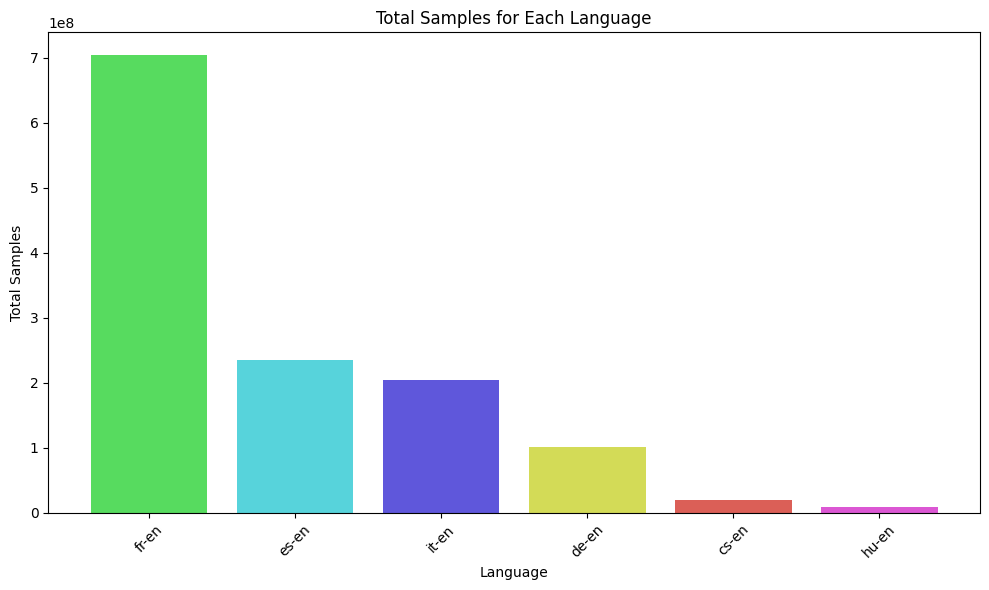

In [26]:
# Usage:
wa.plot_n_samples(lang_dfs_common, color_mapping)
# wa.plot_n_samples(lang_dfs_filtered, color_mapping)

/tmp/ipykernel_3645745/3663324392.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  model_colormap = plt.cm.get_cmap('coolwarm', len(models))


Saved figure to ./results/n-grams/wmt/pile/exp4/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue/1/plots/combined_distributions.png


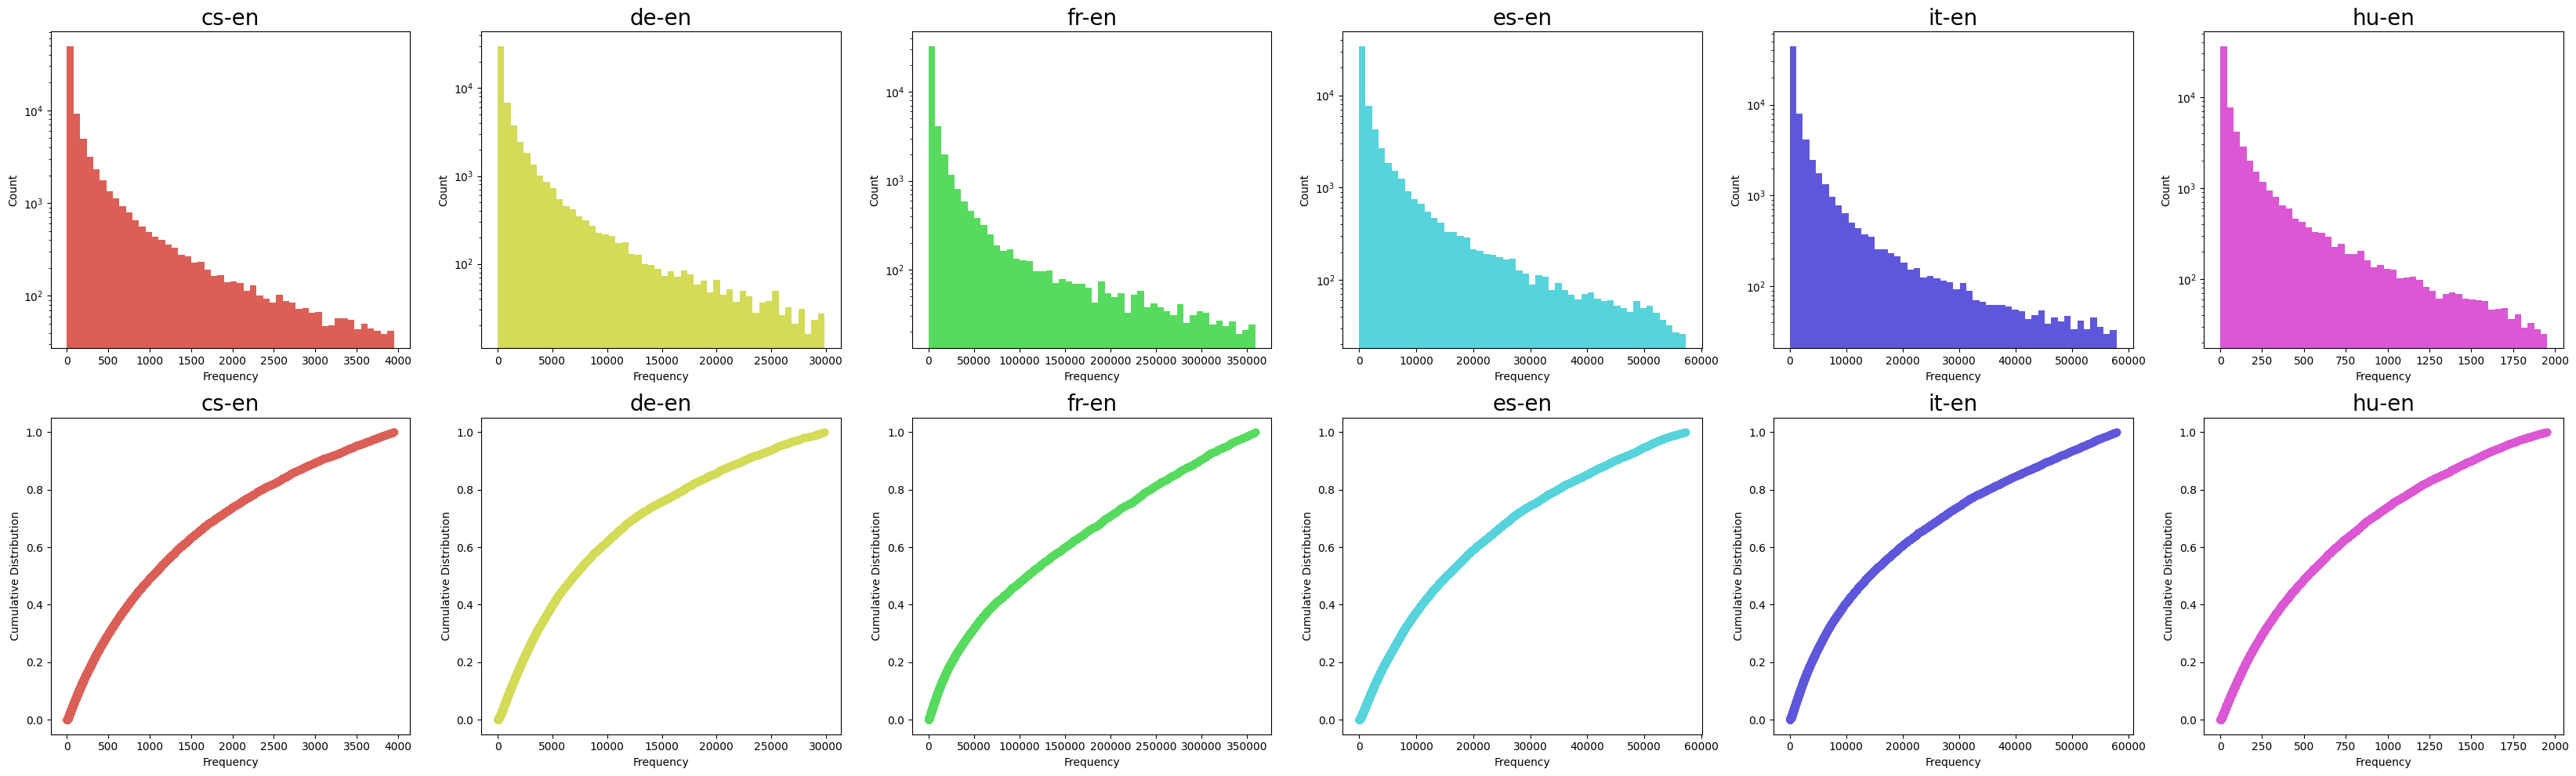

In [27]:
model_colormap = plt.cm.get_cmap('coolwarm', len(models))
model_color_mapping = {model: model_colormap(1 - i / len(models)) for i, model in enumerate(models)}


# wa.analyze_and_plot_distributions(lang_dfs_all)
wa.analyze_and_plot_distributions(lang_dfs_common)

In [28]:
# Initialize a dictionary to hold the contents of results.json for each model/dataset pair
results_dict = collections.defaultdict(dict)

# Iterate over each model and dataset, loading the results.json file
for model in models:
    for lang_dataset in LANGUAGES:
        lang_pair = '-'.join(lang_dataset.split('-')[-2:])
        results_path = os.path.join(base_results_path, model, "TRANSLATION", lang_dataset, '0-shot', 'results.json')
        
        if os.path.exists(results_path):
            with open(results_path, 'r') as file:
                data = json.load(file)
                results_dict[lang_pair][model] = data['results'][lang_dataset]['bleu']
        else:
            print(f"File does not exist: {results_path}")



In [29]:
for key, df in lang_dfs.items():
    print(f"key: {key}, lang_df_task: {df['task'].unique()}")

key: cs-en, lang_df_task: ['cs-en']
key: de-en, lang_df_task: ['de-en']
key: fr-en, lang_df_task: ['fr-en']
key: es-en, lang_df_task: ['es-en']
key: it-en, lang_df_task: ['it-en']
key: hu-en, lang_df_task: ['hu-en']


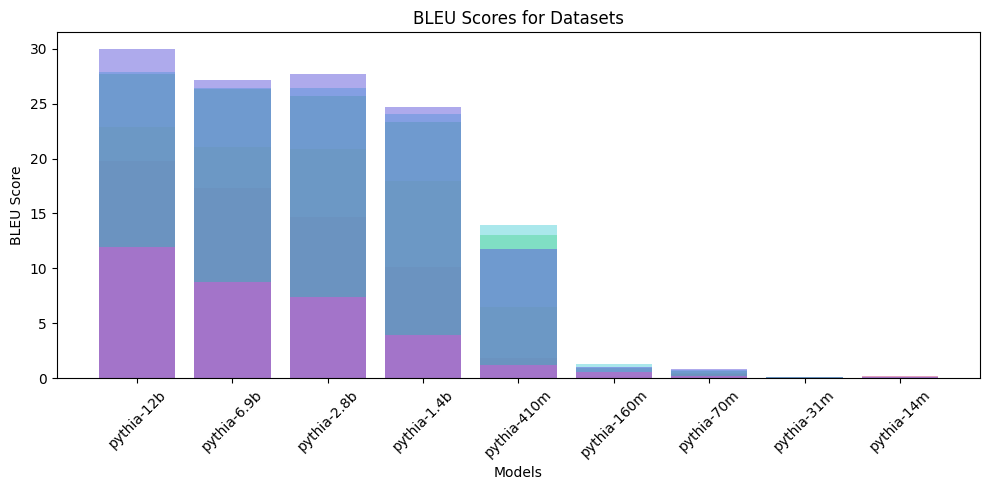

In [30]:
wa.plot_bleu_scores(results_dict, models, color_mapping)

In [31]:
lang_ds = wa.build_lang_ds(lang_dfs.keys())

lang_mutual_info, merged_mutual_info = wa.calculate_mutual_info(lang_dfs, lang_ds)

Loading dataset for language pair ('cs', 'en')
Loading dataset for language pair ('de', 'en')
Loading dataset for language pair ('fr', 'en')
Loading dataset for language pair ('es', 'en')
Loading dataset for language pair ('it', 'en')
Loading dataset for language pair ('hu', 'en')
Loading dataset for language pair ('en', 'cs')
Loading dataset for language pair ('en', 'de')
Loading dataset for language pair ('en', 'fr')
Loading dataset for language pair ('en', 'es')
Loading dataset for language pair ('en', 'it')
Loading dataset for language pair ('en', 'hu')


In [32]:
lang_mutual_info, merged_mutual_info = wa.calculate_mutual_info(lang_dfs, lang_ds)

In [33]:
model_scores, dataset_scores = wa.prepare_scores(results_dict, lang_dfs, models, 
                                                 mutual_info=lang_mutual_info,
                                                 merged_mutual_info=merged_mutual_info)

Saved figure to ./results/n-grams/wmt/pile/exp4/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue/1/plots/lang_scores_XY_pairs.png


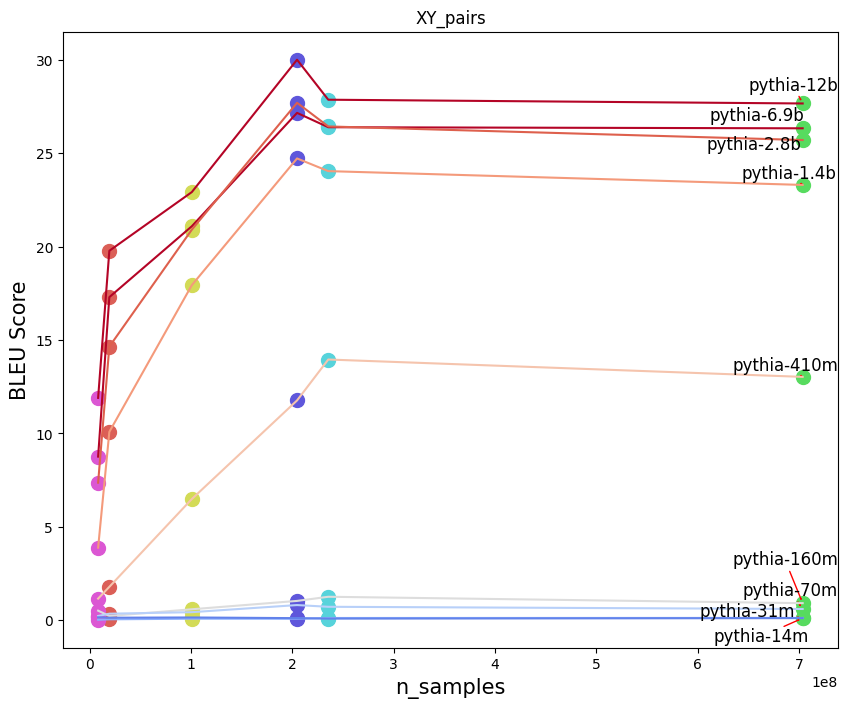

In [42]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

# wa.plot_scores(model_scores, dataset_scores, model_color_mapping, name="XY_pairs")
wa.plot_scores(model_scores, dataset_scores, color_mapping,
               model_color_mapping, name="XY_pairs")

Saved figure to ./results/n-grams/wmt/pile/exp4/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue/1/plots/lang_scores_XY_pairs.png


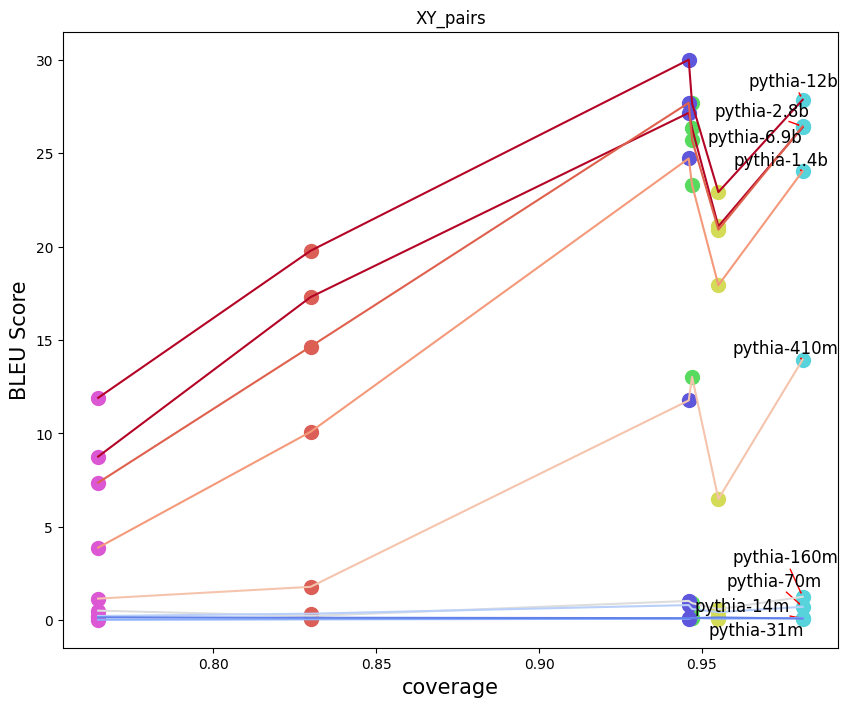

In [43]:
wa.plot_scores(model_scores, dataset_scores, color_mapping,
            model_color_mapping, name="XY_pairs",
            x_key='coverage')


Saved figure to ./results/n-grams/wmt/pile/exp4/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue/1/plots/lang_scores_XY_pairs.png


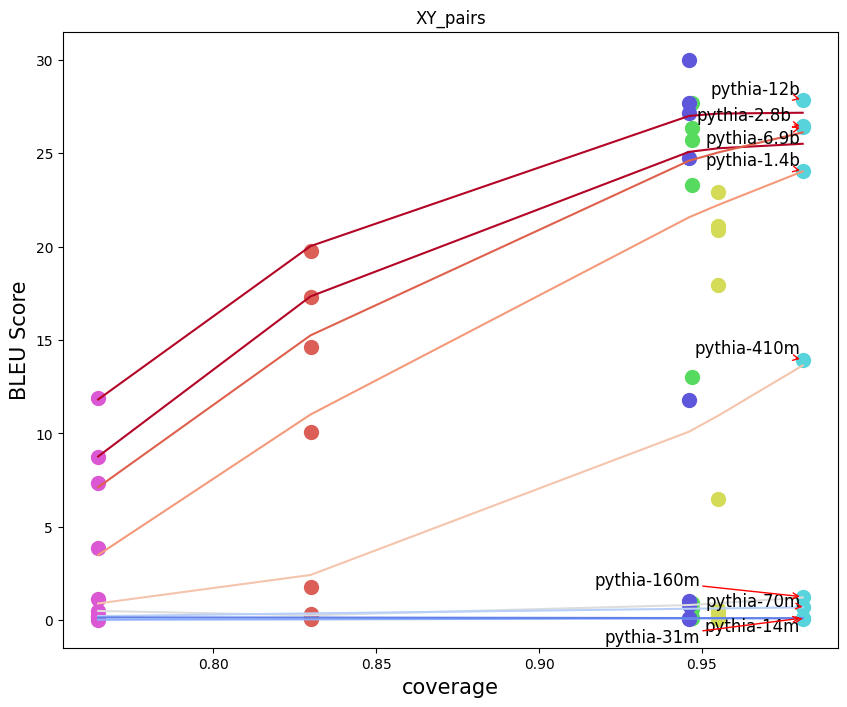

In [ ]:
wa.plot_scores(model_scores, dataset_scores, color_mapping,
            model_color_mapping, name="XY_pairs",
            x_key='coverage', fit_polynomial=2)

Saved figure to ./results/n-grams/wmt/pile/exp4/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue/1/plots/lang_scores_XY_pairs.png


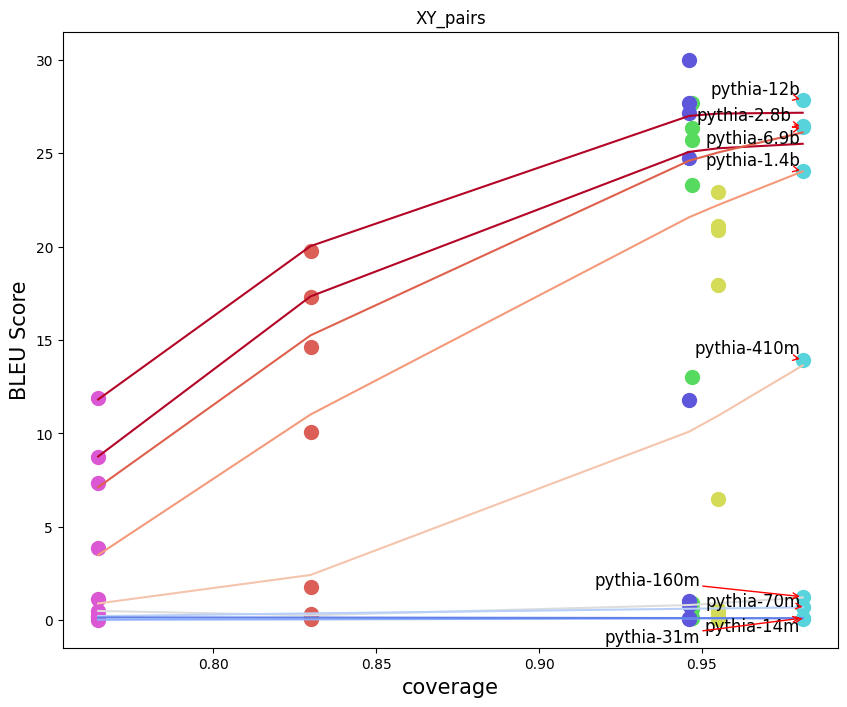

In [ ]:
model_scores_common_0, dataset_scores_common_0 = wa.prepare_scores(results_dict, lang_dfs_common_0, models, 
                                                 mutual_info=lang_mutual_info,
                                                 merged_mutual_info=merged_mutual_info)
wa.plot_scores(model_scores_common_0, dataset_scores_common_0, color_mapping,
            model_color_mapping, name="XY_pairs",
            x_key='coverage', fit_polynomial=2)

Saved figure to ./results/n-grams/wmt/pile/exp4/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue/1/plots/lang_scores_All.png
Saved figure to ./results/n-grams/wmt/pile/exp4/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue/1/plots/lang_scores_All.png


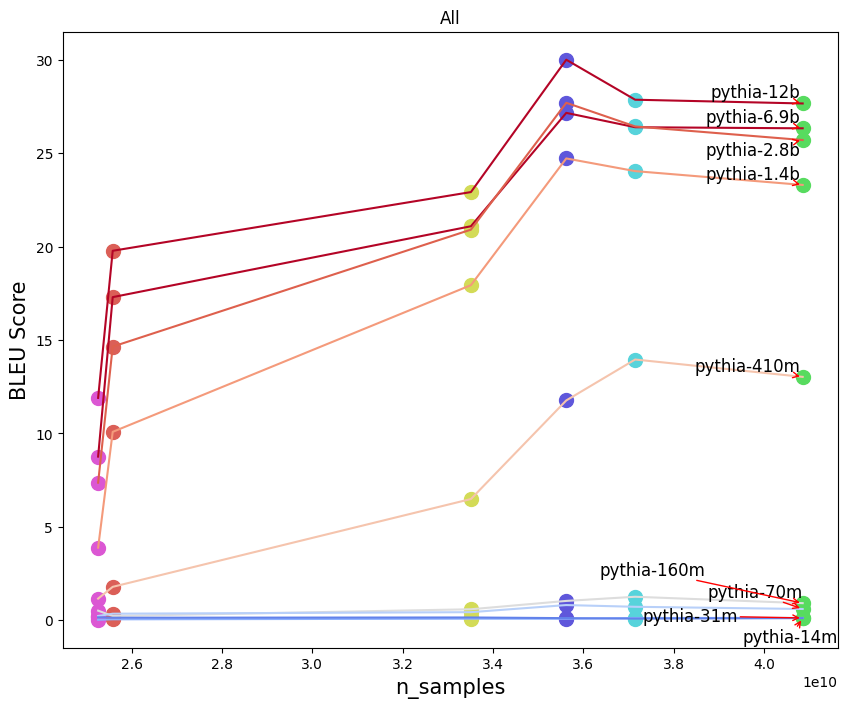

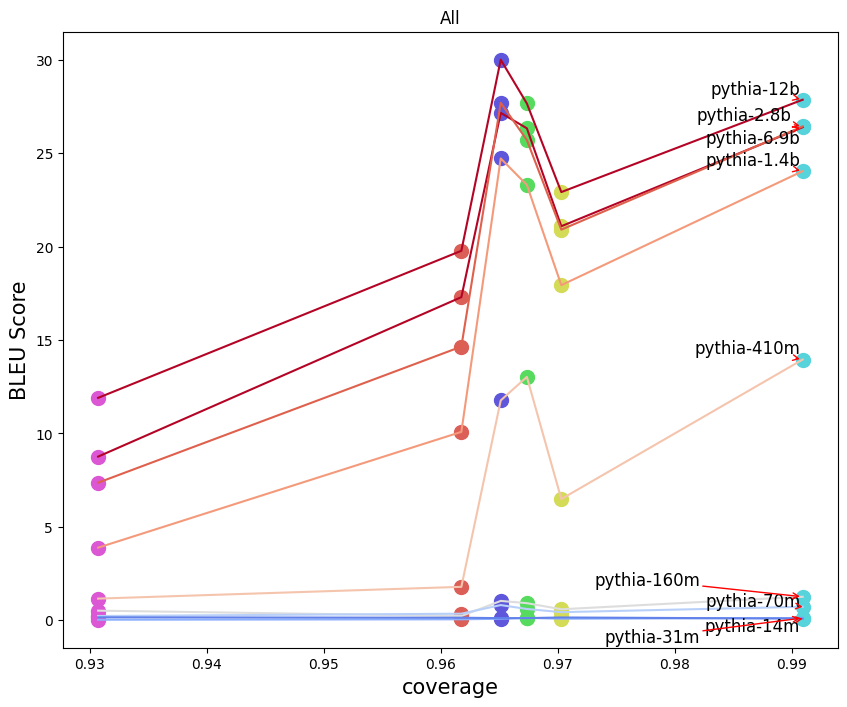

In [ ]:
model_scores_all, dataset_scores_all = wa.prepare_scores(results_dict, lang_dfs_all, models,
                                                         mutual_info=lang_mutual_info,
                                                         merged_mutual_info=merged_mutual_info)
wa.plot_scores(model_scores_all, dataset_scores_all, color_mapping,
                model_color_mapping, name="All")

wa.plot_scores(model_scores_all, dataset_scores_all, color_mapping,
                model_color_mapping, name="All",
                x_key='coverage')

Saved figure to ./results/n-grams/wmt/pile/exp4/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue/1/plots/lang_scores_XY_pairs_filtered.png


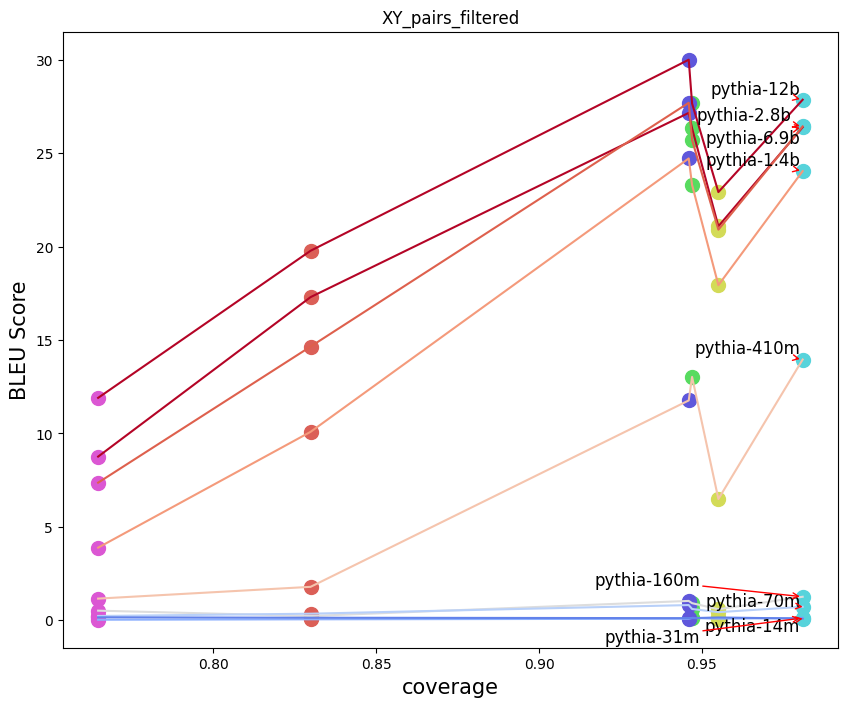

In [ ]:
model_scores_filered, dataset_scores_filtered = wa.prepare_scores(results_dict, lang_dfs_common_filtered, models)
wa.plot_scores(model_scores_filered, dataset_scores_filtered, 
            color_mapping, model_color_mapping,
            name="XY_pairs_filtered", x_key='coverage')


Saved figure to ./results/n-grams/wmt/pile/exp4/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue/1/plots/lang_scores_XY_pairs.png
Saved figure to ./results/n-grams/wmt/pile/exp4/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue/1/plots/lang_scores_XY_pairs.png


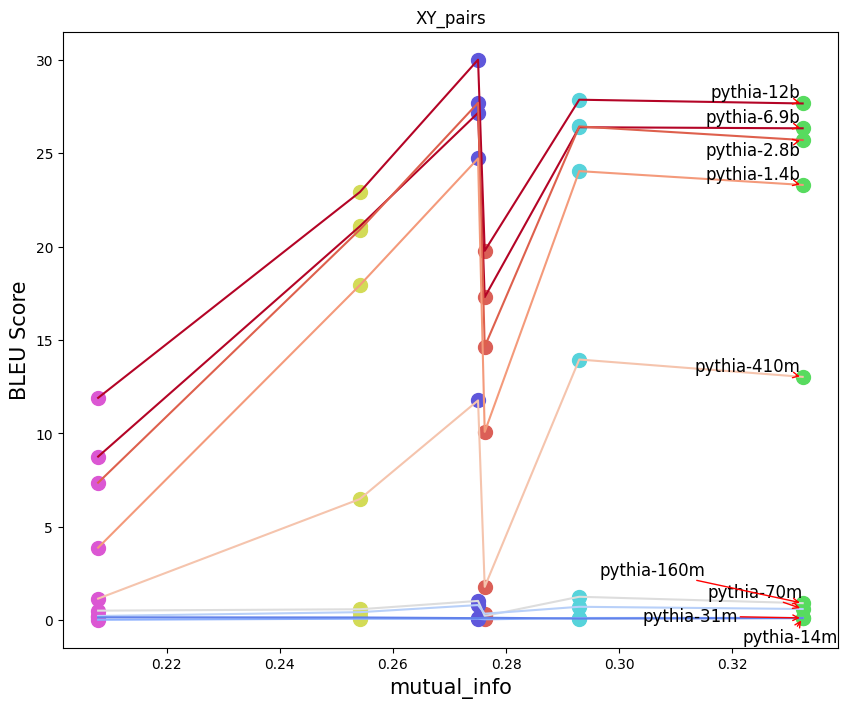

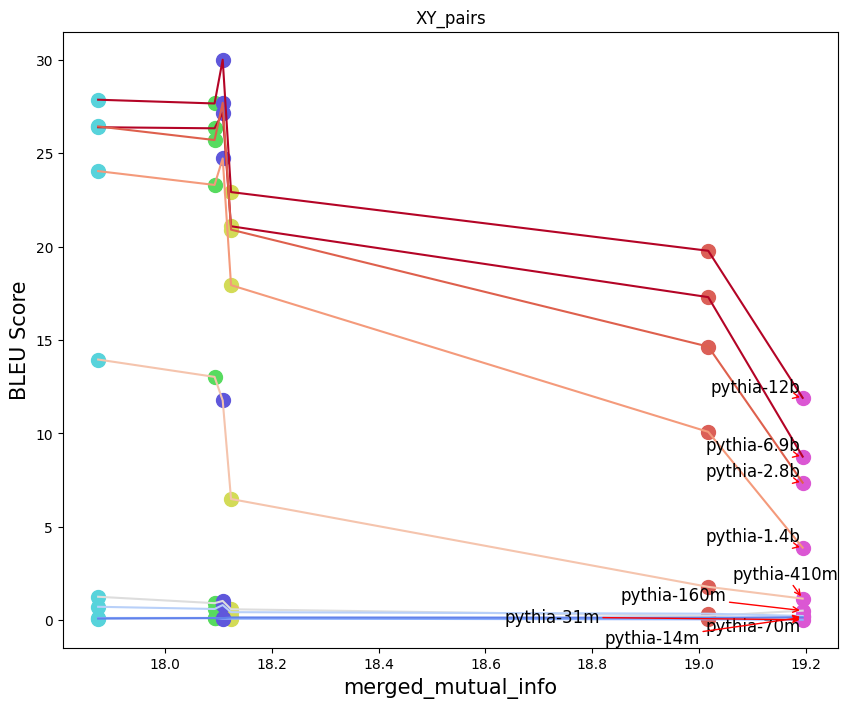

In [ ]:
wa.plot_scores(model_scores, dataset_scores, 
            color_mapping, model_color_mapping,
            name="XY_pairs",
            x_key="mutual_info")

wa.plot_scores(model_scores, dataset_scores, 
            color_mapping, model_color_mapping,
            name="XY_pairs",
            x_key="merged_mutual_info")


Saved figure to ./results/n-grams/wmt/pile/exp4/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue/1/plots/lang_scores_XY_pairs_common.png


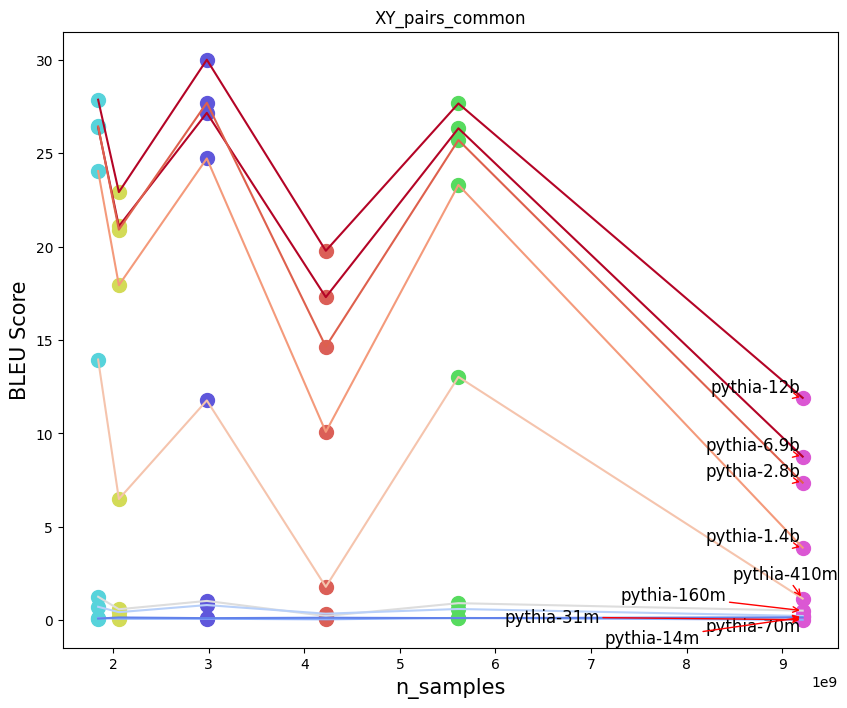

In [ ]:
model_scores_common, dataset_scores_common = wa.prepare_scores(results_dict, lang_dfs_common, models)
wa.plot_scores(model_scores_common, dataset_scores_common, 
            color_mapping, model_color_mapping,
            name="XY_pairs_common")

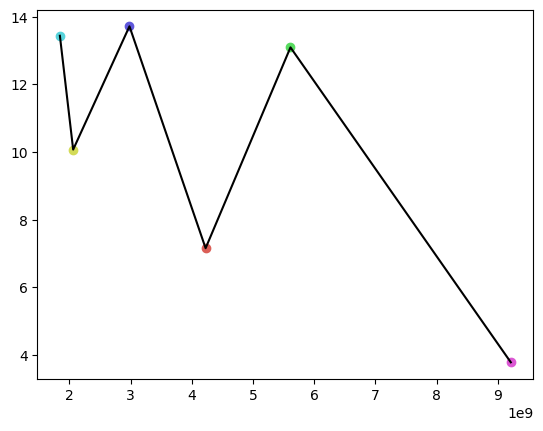

In [ ]:
# plot average line over all models for all datasets
avg_dataset_scores = collections.defaultdict(lambda: collections.defaultdict(list))
avg_scores = {'score': [], 'n_samples': []} 
for dataset in dataset_scores:
    avg_dataset_scores[dataset]['score'] = np.mean(dataset_scores[dataset]['score'])
    avg_dataset_scores[dataset]['n_samples'] = np.mean(dataset_scores[dataset]['n_samples'])
    plt.scatter(avg_dataset_scores[dataset]['n_samples'], avg_dataset_scores[dataset]['score'], 
                color=color_mapping[dataset], label=dataset)
    avg_scores['score'].append(avg_dataset_scores[dataset]['score'])
    avg_scores['n_samples'].append(avg_dataset_scores[dataset]['n_samples'])

# sort by n_samples
avg_scores['score'] = [x for _, x in sorted(zip(avg_scores['n_samples'], avg_scores['score']))]
avg_scores['n_samples'] = sorted(avg_scores['n_samples'])

plt.plot(avg_scores['n_samples'], avg_scores['score'], color='black', label='average')


In [ ]:
results_dict['fr-en'].keys()


dict_keys(['pythia-12b', 'pythia-6.9b', 'pythia-2.8b', 'pythia-1.4b', 'pythia-410m', 'pythia-160m', 'pythia-70m', 'pythia-31m', 'pythia-14m'])

Saved figure to ./results/n-grams/wmt/pile/exp4/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue/1/plots/model_size_vs_scores.png


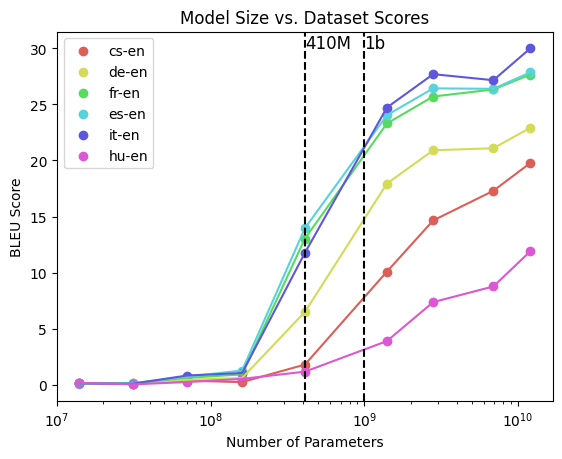

In [ ]:
['pythia-12b', 'pythia-6.9b', 'pythia-2.8b', 'pythia-1.4b', 'pythia-410m', 'pythia-160m', 'pythia-70m', 'pythia-31m', 'pythia-14m']

model_param_map = {'pythia-12b': 12e09,
                    'pythia-6.9b': 6.9e09,
                    'pythia-2.8b': 2.8e09,
                    'pythia-1.4b': 1.4e09,
                    'pythia-410m': 410e06,
                    'pythia-160m': 160e06,
                    'pythia-70m': 70e06,
                    'pythia-31m': 31e06,
                    'pythia-14m': 14e06,}

wa.plot_model_size_vs_scores(results_dict, models, model_param_map, color_mapping)


In [ ]:
# get total samples per language
lang_dfs_all_total_samples = {}
for lang, df in lang_dfs_all.items():
    lang_dfs_all_total_samples[lang] = df['value'].sum()

model_scores_all, dataset_scores_all = wa.prepare_scores(results_dict, lang_dfs_all, models)


In [ ]:
# n_gram_freqs_all['ja-en']['value'] = pd.to_numeric(n_gram_freqs_all['ja-en']['value'], errors='coerce')
# largest_values = n_gram_freqs_all['ja-en'].nlargest(50, columns=['value'])

# print(largest_values)


Saved figure to ./results/n-grams/wmt/pile/exp4/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue/1/plots/lang_scores_all_instances_NGRAM=1.png


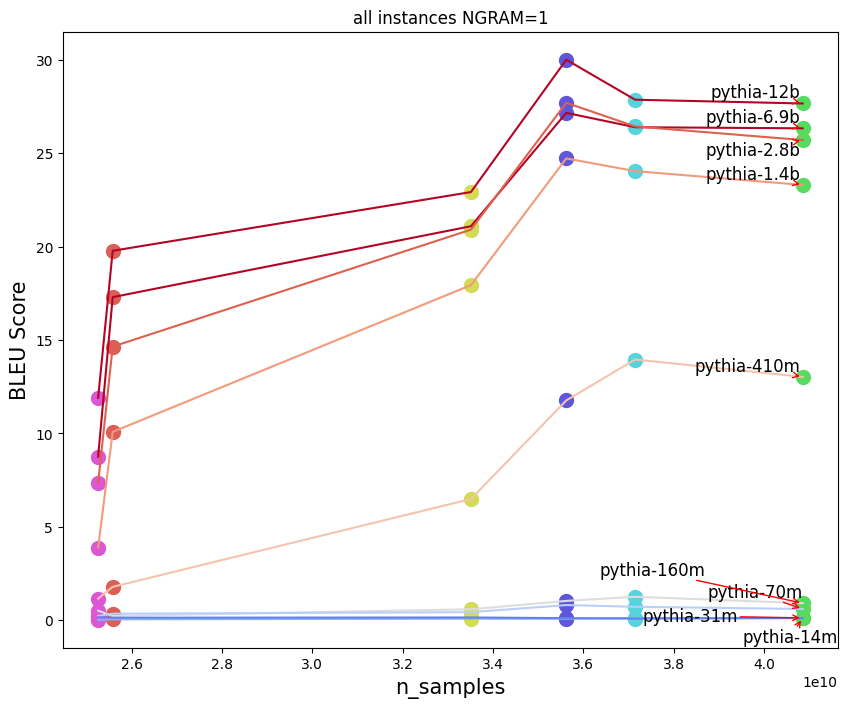

In [ ]:
wa.plot_scores(model_scores_all, dataset_scores_all, 
            color_mapping, model_color_mapping, 
            name=f"all instances NGRAM={N_GRAMS}")

# wa.plot_scores(model_scores_all, dataset_scores_all, 
#             color_mapping, model_color_mapping, 
#             name=f"all instances NGRAM={N_GRAMS}",
#             x_key="coverage")

Saved figure to ./results/n-grams/wmt/pile/exp4/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue/1/plots/lang_scores_XY_pairs.png


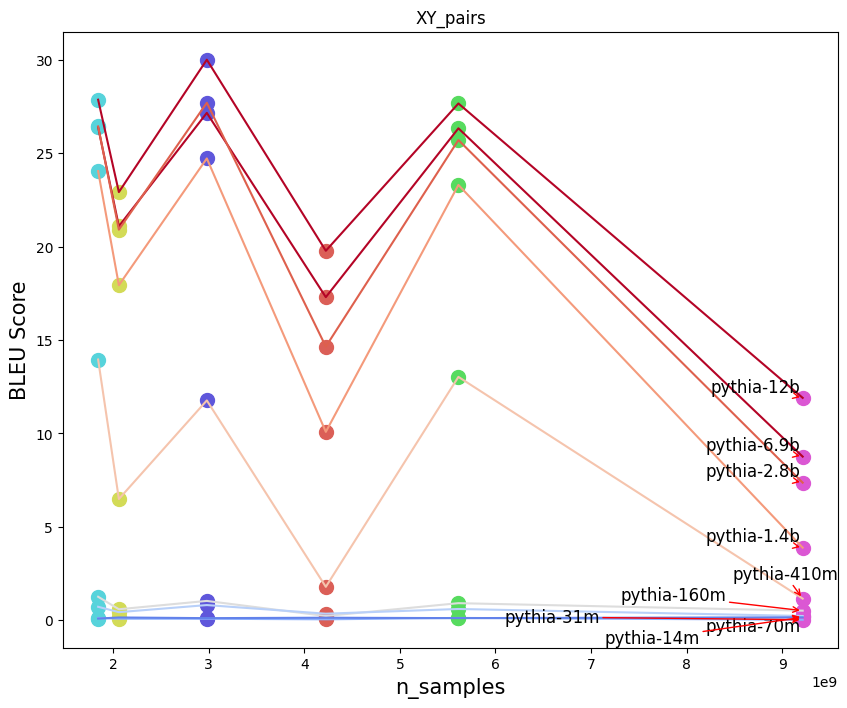

In [ ]:
wa.plot_scores(model_scores, dataset_scores, 
            color_mapping, model_color_mapping, 
            name="XY_pairs")


In [ ]:
lang_dfs_all.keys()


dict_keys(['cs-en', 'de-en', 'fr-en', 'es-en', 'it-en', 'hu-en'])

In [ ]:
lang = 'fr'

for lang_pair in lang_dfs_all:
    print(f"lang_pair: {lang_pair}")
    lang = lang_pair.split('-')[0]
    print(f"lang: {lang}")
    lang_en_all = lang_dfs_all[f'{lang}-en']
    lang_only = lang_en_all[lang_en_all['lang'] == lang]
    print(f"lang all: {len(lang_en_all)} only: {len(lang_only)} diff: {len(lang_en_all) - len(lang_only)}")


lang_pair: cs-en
lang: cs


KeyError: 'lang'

In [ ]:
lang = 'fr'

for lang_pair in lang_dfs:
    lang = lang_pair.split('-')[0]
    lang_en_all = lang_dfs_all[f'{lang}-en']
    lang_only = lang_en_all[lang_en_all['lang'] == lang]
    print(f"lang all: {len(lang_en_all)} only: {len(lang_only)} diff: {len(lang_en_all) - len(lang_only)}")

lang_dfs_all_single = {lang_pair: df[df['lang'] == lang_pair.split('-')[0]] for lang_pair, df in lang_dfs_all.items()}
model_scores_all_single, dataset_scores_all_single = wa.prepare_scores(results_dict, lang_dfs_all_single, models)


In [ ]:
wa.plot_scores(model_scores_all_single, dataset_scores_all_single, 
            color_mapping, model_color_mapping, 
            name="all single instances")